In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import namedtuple

# Velocity curve definition

We wish to be able to generate an arbitrary "constant-jerk" velocity function, which we can interrogate to find the velocity at any point in time `t`.

In [2]:
TEND = 1.0

Curve = namedtuple("Curve", ["J", "A0", "T", "AT", "VT", "accFn", "velFn", ])
def gen_constant_jerk_polynomial(A0, AT, T=TEND):
    J = (AT-A0)/T
    accFn = lambda t: A0 + J*t
    velFn = lambda t: A0*t + (J/2)*(t**2)
    return Curve(J, A0, T, accFn(T), velFn(T), accFn, velFn)

c = gen_constant_jerk_polynomial(A0=0, AT=1, T=1)
print(f"Example with A0=0, AT=1, T=1:\n\nV={c.velFn(0)} @ T=0\nV={c.velFn(0.5)} @ T=0.5\nV={c.velFn(1.0)} @ T=1.0")

Example with A0=0, AT=1, T=1:

V=0.0 @ T=0
V=0.125 @ T=0.5
V=0.5 @ T=1.0


# Generate curve functions

Here we select a range of curve functions to generate. min and max `a` and `j` are given (perhaps a property of the robot itself).

Min/max `v` is computed based on these variables; note that velocity limits can be given to `Ruckig` which will limit the actual robot velocity.

We start with some simple analysis to see what space limitations we have on the microcontroller for storing all this data...

In [4]:
NSAMP = 128
max_bytes = 768000
word_size = 2 # int16_t
max_num_curves = max_bytes / (word_size * NSAMP)
print(f"System memory: {max_bytes}B")
print(f"Each curve is {NSAMP} samples of {word_size} bytes")
print(f"max {int(max_num_curves)} curves storable")

System memory: 768000B
Each curve is 128 samples of 2 bytes
max 3000 curves storable


In [5]:
max_a = 3
min_a = -3

min_j = -0.5
max_j = 0.5

# Max velocity happens when zero jerk at max limit of acceleration
max_v = 0.5*(0)*(TEND**2) + max_a*TEND
# Min velocity happens when max negative jerk starting at 0 accel
min_v = 0.5*min_j*(TEND**2) + (0)*TEND
print(f"min_v {min_v}, max_v {max_v}")

# compute number of starting and ending acceleration values, to get 
# total number of curves
num_a0 = 39
assert num_a0 % 2 == 1, "num_a0 must be even to allow for constant-velocity curve"
num_a = num_a0*2+1 #math.floor(-1 + math.sqrt(1 - 4*0.5*(-max_num_curves)))
print(f"num_a: {num_a}, num_a0: {num_a0}")

curves = [
    gen_constant_jerk_polynomial(A0, AT) 
    for AT in np.linspace(min_a, max_a, num_a)
    for A0 in np.linspace(0, max_a, num_a0)
]
jerks = [c.J for c in curves]
print(f"Generated {len(curves)} curves (est. {len(curves)*NSAMP*2 / 1024}KB)")

min_v -0.25, max_v 3.0
num_a: 79, num_a0: 39
Generated 3081 curves (est. 770.25KB)


Showing a sample of ~50 curves:


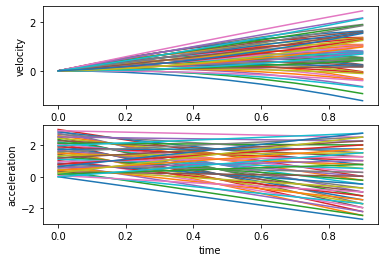

In [6]:
# Plot them
plt.subplot(211); plt.xlabel("time"); plt.ylabel("velocity")
plt.subplot(212); plt.xlabel("time"); plt.ylabel("acceleration")
nshow = 50
print(f"Showing a sample of ~{nshow} curves:")
time = np.arange(0, 1.0, 0.1)
for i, c in enumerate(curves):
    if i % int(len(curves)/nshow) != 0:
        continue
    plt.subplot(211); plt.plot(time, np.array([c.velFn(t) for t in time]))
    plt.subplot(212); plt.plot(time, np.array([c.accFn(t) for t in time]))
plt.show()

# Test with "real" intents

The following `intent_set` was generated by running `python3 control/curvegen.py` with a functional instlalation of `Ruckig` to generate motion paths. 

The values here are in "real" values so it's easier to reason about. Further down we do the same with "baked" values such as the microcontroller would see.

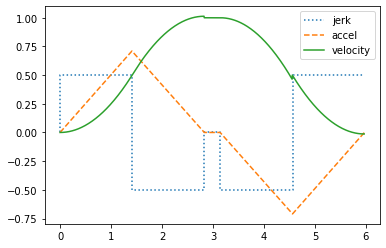

In [7]:
# Copied from inputs/curvegen.py
intent_set = [ # curve_id, scale, shift, t_sec
(2028, 1, 0.0, 1.4142135623730951),
(1534, 1, 0.5000000000000001, 1.4142135623730951),
(1521, 1, 1.0000000000000002, 0.3131655252538099),
(975, 1, 1.0000000000000002, 1.4142135623730951),
(1534, -1, 0.5000000000000001, 1.4142135623730951),

]
expected_t = [0,  1.41, 2.83, 3.14, 4.56, 5.97]

expected_j = [0, 0.5, -0.5, 0, -0.5, 0.5]
plt.step(expected_t, expected_j, label="jerk", linestyle="dotted")

expected_a = [0, 0.71, 0, 0, -0.71, 0]
plt.plot(expected_t, expected_a, label="accel", linestyle="dashed")

t_step = 0.01
t_start = 0
vals = []
times = []
for (curve_id, scale, shift, t_amt) in intent_set:
    c = curves[curve_id]
    for t in np.arange(0, t_amt, t_step):
        curve_t = t / t_amt
        vals.append(c.velFn(curve_t)*scale + shift)
        times.append((t_start + t))
    t_start += t_amt

plt.plot(times, vals, label="velocity")
plt.legend(loc="best")
plt.show()

# Export curves.c

Here we generate the curves.c file.

Boundary detection is run on all samples to find the best fit into
the data type (`int16_t`) to maximize vertical resolution without
having to shift the data vertically

In [8]:
data = np.array([[c.velFn(s) for s in np.linspace(0, c.T, NSAMP)] for c in curves])

v_bound_min = np.amin(data)
v_bound_max = np.amax(data)
vel_scale = int((2**15-1) / (max(abs(v_bound_min), abs(v_bound_max))))
print(f"v_bound_min={v_bound_min}, v_bound_max={v_bound_max} -> vel_scale={vel_scale}")

data = (data * vel_scale).astype(int)
assert np.amax(data) < 32767, f"Max exceeds bounds of 16-bit integer: got {np.amax(data)}"
assert np.amin(data) > -32768, f"Min exceeds bounds of 16-bit integer: got {np.amin(data)}"

def make_curves_c_file(curves):
    
    vel_data = []
    js = []
    a0s = []
    for i, c in enumerate(curves):
        js.append(c.J)
        a0s.append(c.A0)
        vel_data.append(str(data[i]).replace("[", "{").replace("]", "}"))
    
    return (
        f"// THIS FILE IS AUTO GENERATED - DO NOT MODIFY\n" +
        f"// See curve_generator.ipynb for details\n" + 
        f"#include \"curves.h\"\n\n" +
        f"const int16_t CURVES_MAX_V = {int(max_v*256)}; //8-bit fixed point\n" +
        f"const int16_t CURVES_MIN_V = {int(min_v*256)}; //8-bit fixed point\n" +
        f"const int16_t VEL_SCALE = {int(vel_scale*256)}; //8-bit fixed point\n" +
        f"const int32_t CURVES_T_END_USEC = {int(TEND*1000000)};\n" +
        "const uint16_t CURVES[][CURVE_SZ] = {\n" +
        f",\n  ".join(vel_data) +
        "\n};"
    )

with open("./curves.c", "w") as f:
    f.write(make_curves_c_file(curves))
print("wrote curves.c")

v_bound_min=-1.5, v_bound_max=3.0 -> vel_scale=10922
wrote curves.c


# Baked intents

Let's try drawing a curve by using the "encoded" intents which would normally be passed to the microcontroller over UART. 

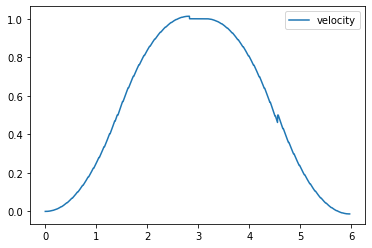

In [9]:
# Baked intents this time!
intent_set = [
(2028, 6, 0, 1414213),
(1534, 6, 128, 1414213),
(1521, 6, 256, 313165),
(975, 6, 256, 1414213),
(1534, -6, 128, 1414213),

]
# plt.step(expected_t, expected_j, label="jerk", linestyle="dotted")
# plt.plot(expected_t, expected_a, label="accel", linestyle="dashed")

t_step = 0.01
t_start = 0
vals = []
times = []
for (curve_id, scale, shift, t_amt) in intent_set:
    baked = data[curve_id]
    t_amt /= 1000000
    for t in np.arange(0, t_amt, t_step):
        i = int(t / t_amt * NSAMP)
        vals.append(baked[i]*(scale / (2**16)) + (shift / (2**8)))
        times.append((t_start + t))
    t_start += t_amt

plt.plot(times, vals, label="velocity")
plt.legend(loc="best")
plt.show()